In [505]:
import pandas  as pd
import os
from pathlib import Path

In [506]:
BASE_DIR = Path(os.path.dirname(os.path.abspath('esi-trabalho-final'))).parent

In [507]:
BASE_DIR = str(BASE_DIR)

In [508]:
data = pd.read_csv(BASE_DIR+'\\data\\'+'data.csv')

In [509]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [510]:
data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [511]:
data.nunique()

date               70
price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64

In [512]:
data.nunique().index

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [513]:
data.drop('country', axis=1, inplace=True)

In [514]:
data[data['price'] <= 0]['price'].unique()

array([0.])

In [515]:
def remove_casa_free(df):
    index = df[df['price'] <= 0].index
    return df.drop(index=index)

In [516]:
data = remove_casa_free(data)

In [517]:
import tensorflow as tf
import keras

In [518]:
def tokenizer_text(data):
    vectorizer = keras.layers.TextVectorization(
        output_mode='int',
        output_sequence_length=15,
        standardize='lower_and_strip_punctuation',
    )
    # unindo colunas de
    data['location'] = data['street'] + ' ' + data['city'] + ' ' + data['statezip'] 

    # vetorizando
    vectorizer.adapt(data['location'].values)
    tokenizer_text = vectorizer(data['location'].values)

    return tokenizer_text, vectorizer.vocabulary_size()

In [519]:
subset, vocab_size = tokenizer_text(data)

In [520]:
def global_mean(token, input,embedding_dim=5):
    """Aplica GlobalAveragePooling1D para reduzir a dimensionalidade do token."""
    ebedding_dim = 5
    embedding = keras.layers.Embedding( 
        input_dim=input,
        output_dim=embedding_dim,
    )
    token = embedding(token)

    # Aplicando GlobalAveragePooling1D
    token = keras.layers.GlobalAveragePooling1D()(token)

    return token.numpy()

In [521]:
subset = global_mean(subset, vocab_size)

In [522]:
def to_colunmns(data, subset):
    for i in range(subset.shape[1]):
        data[f'char_token_{i}'] = subset[:, i]

    return data

In [523]:
def remove_columns(df, columns_to_remove):
    return df.drop(columns_to_remove, axis=1)

In [524]:
data = remove_columns(data, ['street', 'city', 'statezip', 'location'])

In [525]:
def arrendondamento(data):
    data['bathrooms'] = data['bathrooms'].astype(int)
    return data

In [526]:
from sklearn.preprocessing import StandardScaler
def padronizacao(data):
    scaler = StandardScaler()
    for i in ['sqft_living', 'sqft_lot','sqft_above', 'sqft_basement']:
        data[i] = scaler.fit_transform(data[[i]].astype(float).values)
    return data

In [527]:
data = padronizacao(data)

In [528]:
data = to_colunmns(data, subset)

In [529]:
data['char_token_0']

0      -0.007966
1      -0.002174
2       0.001715
3       0.001644
4      -0.000633
          ...   
4595   -0.008779
4596    0.008601
4597    0.007637
4598   -0.004032
4599    0.005406
Name: char_token_0, Length: 4551, dtype: float32

In [530]:
def dummies(data):
    return pd.get_dummies(data=data, columns=['floors', 'waterfront', 'view', 'condition'], dtype=int)

In [531]:
data = dummies(data)

In [532]:
data = arrendondamento(data)

In [533]:
import numpy as np
def transformacao_log(data):
    data['price'] = np.log1p(data['price'])
    return data

In [ ]:
from sklearn.mixture import GaussianMixture
def gaussian_outliers(data):
    X = data['price'].values.reshape(-1, 1)

    #logging.info("Aplicando gaussian_outliers para a coluna price...")
    gm = GaussianMixture(n_components=1)
    gm.fit(X)
    

    densidade = gm.score_samples(X)
    #logging.info(f'Percentil 4: {np.percentile(densidade, 4)}')
    densidade_threshold = np.percentile(densidade, 4)

    # Máscara booleana para identificar outliers
    outlier_mask = densidade < densidade_threshold

    # Índices dos outliers
    outlier_indices = data.index[outlier_mask]

    (f'Quantidade de outliers: {len(outlier_indices)}')

    # Retorna DataFrame sem os outliers
    return data.drop(index=outlier_indices)

In [535]:
data = gaussian_outliers(data)

TypeError: unsupported operand type(s) for -: 'GaussianMixture' and 'GaussianMixture'

In [ ]:
data = transformacao_log(data)

<Axes: >

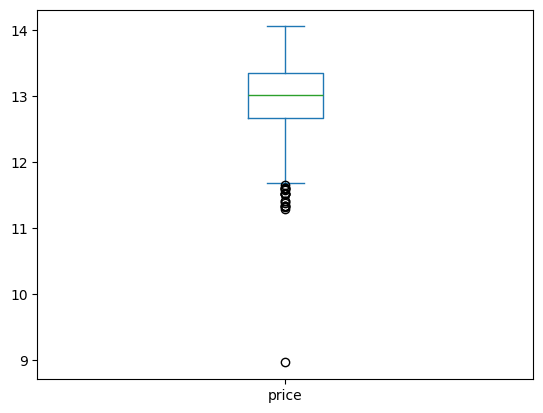

In [ ]:
data['price'].plot.box()

In [ ]:
X = data.drop(['price','date'], axis=1).values

In [ ]:
y = data['price'].values

In [ ]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,...,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5
0,2014-05-02 00:00:00,12.653962,3.0,1,-0.828976,-0.192527,-0.564425,-0.671413,1955,2005,...,1,0,0,0,0,0,0,1,0,0
2,2014-05-02 00:00:00,12.742569,3.0,2,-0.211721,-0.080319,0.126151,-0.671413,1966,0,...,1,0,0,0,0,0,0,0,1,0
3,2014-05-02 00:00:00,12.948012,3.0,2,-0.138487,-0.189245,-0.962384,1.493385,1963,0,...,1,0,0,0,0,0,0,0,1,0
4,2014-05-02 00:00:00,13.217675,4.0,2,-0.201259,-0.120558,-0.798519,1.060425,1976,1992,...,1,0,0,0,0,0,0,0,1,0
5,2014-05-02 00:00:00,13.102163,2.0,1,-1.310226,-0.235129,-1.102840,-0.671413,1938,1994,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,12.638399,3.0,1,-0.651123,-0.235686,-0.365446,-0.671413,1954,1979,...,1,0,0,0,0,0,0,0,1,0
4596,2014-07-09 00:00:00,13.188777,3.0,2,-0.703433,-0.201954,-0.423969,-0.671413,1983,2009,...,1,0,0,0,0,0,0,1,0,0
4597,2014-07-09 00:00:00,12.940614,3.0,2,0.918170,-0.217499,1.390257,-0.671413,2009,0,...,1,0,0,0,0,0,0,1,0,0
4598,2014-07-10 00:00:00,12.222935,4.0,2,-0.044330,-0.228177,-0.880452,1.536681,1974,0,...,1,0,0,0,0,0,0,1,0,0


### modelo 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
mean_squared_error(y, rf.predict(X))

0.014481932510624709

In [ ]:
r2_score(y, rf.predict(X))

0.9354428956027209

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
sgd = SGDRegressor()
sgd.fit(X, y)

SGDRegressor()

In [ ]:
mean_squared_error(y, sgd.predict(X))

9.072235203309345e+29

In [ ]:
r2_score(y, sgd.predict(X))

-4.044192546174541e+30

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr = SVR()
svr.fit(X, y)

SVR()

In [ ]:
svr.score(X, y) 

0.009196149296395673

In [ ]:
r2_score(y, svr.predict(X))

0.009196149296395673

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [ ]:
lr.score(X, y)

0.46900879054485867

In [ ]:
r2_score(y, lr.predict(X))

0.46900879054485867

In [ ]:
from sklearn.linear_model import RANSACRegressor

In [ ]:
ransac = RANSACRegressor(
    estimator=LinearRegression(),
    max_trials=100
)

ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression())

In [ ]:
ransac.score(X, y)

0.3495007463035448

In [ ]:
RANSACRegressor

sklearn.linear_model._ransac.RANSACRegressor